## TextClass-Benchmark
## Meta-Elo Rating Plot
**Bastián González-Bustamante** \
**https://textclass-benchmark.com**

## Best model for trend

In [2]:
## Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime

## Datasets
f1_elo_df = pd.read_csv('../results/meta_elo/meta_elo_scores.csv')
## f1_elo_df = pd.read_csv('../results/meta_elo/meta_elo_baseline.csv') ## For arXiv paper
params_df = pd.read_csv('../data/mapping_models/deployment_mapping.csv')

## Rename and merge
f1_elo_df['F1-Score'] =  f1_elo_df['Weighted F1']
merged_df = pd.merge(f1_elo_df, params_df, on='Model')

## Filter out models with F1-Score below X
## filtered_df = merged_df[merged_df['F1-Score'] >= 0.60].copy()
filtered_df = merged_df

## Define independent and dependent variables
x = filtered_df['F1-Score']
y = filtered_df['Meta-Elo']

## Models frame
models = {}

## Linear model
linear_coefficients = np.polyfit(x, y, 1)
linear_fit = np.poly1d(linear_coefficients)
models['Linear'] = linear_fit

## Quadratic model
quad_coefficients = np.polyfit(x, y, 2)
quad_fit = np.poly1d(quad_coefficients)
models['Quadratic'] = quad_fit

## Logarithmic model
log_x = np.log(x)
log_coefficients = np.polyfit(log_x, y, 1)
log_fit = lambda x: log_coefficients[0] * np.log(x) + log_coefficients[1]
models['Logarithmic'] = log_fit

## Exponential model
log_y = np.log(y)
exp_coefficients = np.polyfit(x, log_y, 1)
exp_fit = lambda x: np.exp(exp_coefficients[1]) * np.exp(exp_coefficients[0] * x)
models['Exponential'] = exp_fit

## Test models
results = []
for model_name, model in models.items():
    if model_name == 'Logarithmic': 
        predictions = model(x)
    else:
        predictions = model(x)

    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    results.append({'Model': model_name, 'R2': r2, 'MSE': mse})

## Convert results to dataFrame and print
results_df = pd.DataFrame(results)
print(results_df)

## Best model
best_model = results_df.loc[results_df['R2'].idxmax()]
print(f"Best Model: {best_model['Model']} with R2 = {best_model['R2']:.3f} and MSE = {best_model['MSE']:.3f}")

         Model        R2           MSE
0       Linear  0.189985  35905.509956
1    Quadratic  0.307714  30686.945206
2  Logarithmic  0.221829  34493.977010
3  Exponential  0.167244  36913.551282
Best Model: Quadratic with R2 = 0.308 and MSE = 30686.945


## Plot

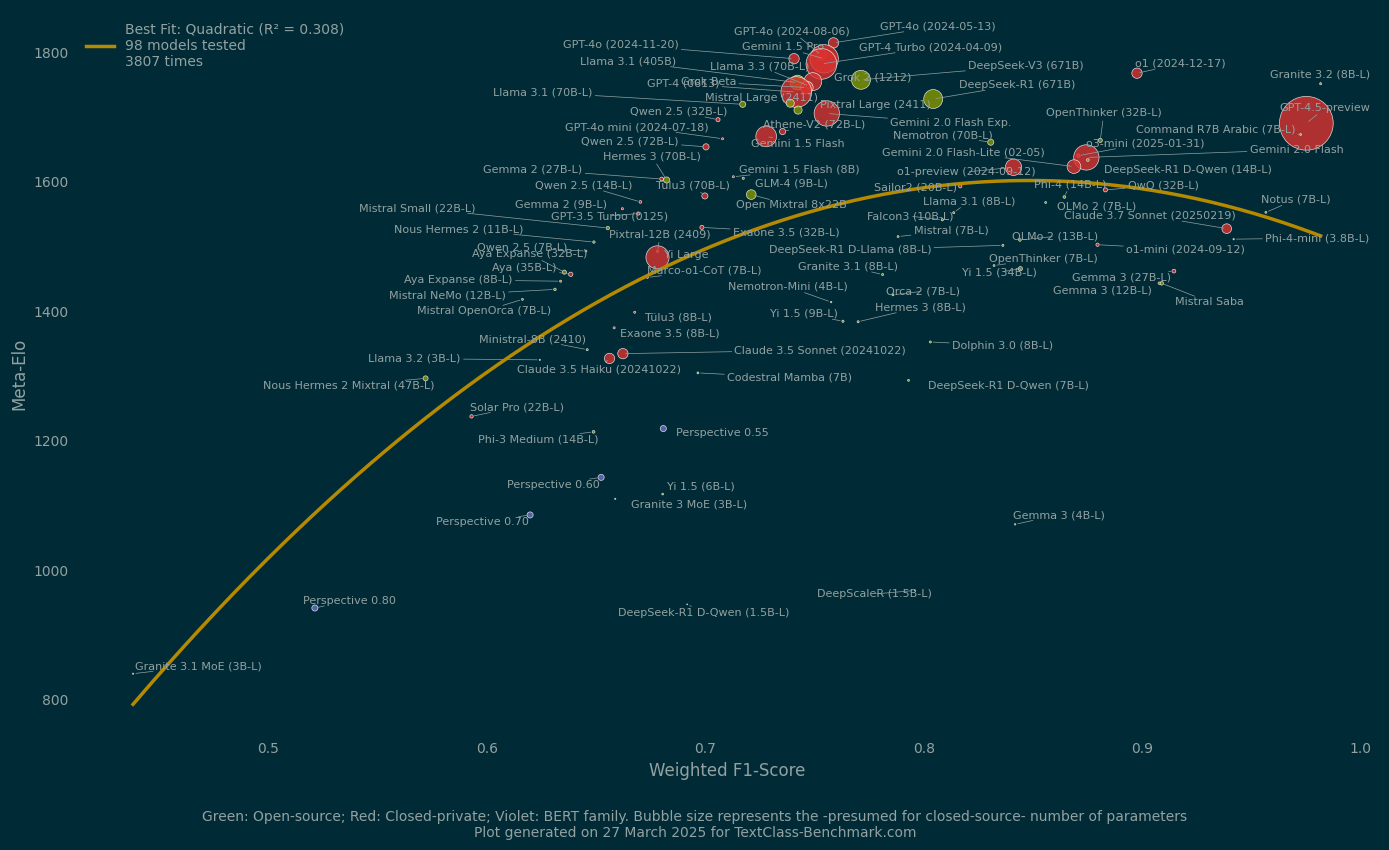

In [3]:
## For adjustText randomness at certain degree
np.random.seed(86)

## Current date
current_date = datetime.now().strftime('%d %B %Y') 

## Normalise parameters for bubble sizes
filtered_df.loc[:, 'Bubble_Size'] = filtered_df['Parameters'] / filtered_df['Parameters'].max() * 1500 ## Increase bubble scale

## Define bubble colors
def get_color(source):
    if source == "Open":
        return '#859900' ## Green
    elif source == "Closed":
        return '#dc322f' ## Red
    elif source == "BERT":
        return '#6c71c4' ## Violet

filtered_df.loc[:, 'Color'] = filtered_df['Source'].apply(get_color)

# Create the plot with a dark background
## plt.figure(figsize=(12, 8), facecolor='#002b36')  ## Size and background
plt.figure(figsize=(14, 8), facecolor='#002b36') ## Size and background

## Scatter plot with colors based on Source category
scatter = plt.scatter(
    filtered_df['F1-Score'], 
    filtered_df['Meta-Elo'], 
    s=filtered_df['Bubble_Size'], 
    alpha=0.8,
    color=filtered_df['Color'], 
    edgecolors='white',
    linewidth=0.5
)

## Count benchmarks
num_unique_models = f1_elo_df['Model'].nunique()
num_test = f1_elo_df['Cycles'].sum()

## Plot the best-fit model
x_range = np.linspace(min(x), max(x), 500)
if best_model['Model'] == 'Logarithmic':
    ## plt.plot(x_range, models['Logarithmic'](x_range), color='#b58900', linewidth=2.5, label='Best Fit: Logarithmic')
    plt.plot(x_range, models['Logarithmic'](x_range), color='#b58900', linewidth=2.5, label=f"Best Fit: Logarithmic (R² = {best_model['R2']:.3f})\n{num_unique_models} models tested\n{num_test} times")
else:
    ## plt.plot(x_range, models[best_model['Model']](x_range), color='#b58900', linewidth=2.5, label=f"Best Fit: {best_model['Model']}")
    plt.plot(x_range, models[best_model['Model']](x_range), color='#b58900', linewidth=2.5, label=f"Best Fit: {best_model['Model']} (R² = {best_model['R2']:.3f})\n{num_unique_models} models tested\n{num_test} times")

## Add model labels
texts = [
    plt.text(row['F1-Score'], row['Meta-Elo'], row['Model'], fontsize=8, ha='center', color='#93a1a1') ## Light text color
    for _, row in filtered_df.iterrows()
]

## Use adjustText to dynamically adjust labels
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#93a1a1', lw=0.5))

## Set axis labels
plt.xlabel('Weighted F1-Score', fontsize=12, color='#93a1a1')
plt.ylabel('Meta-Elo', fontsize=12, color='#93a1a1')

## Set custom axis limits and ticks
## plt.xlim(0.7, 0.9) 
## plt.ylim(1400, 1700)
plt.tick_params(axis='y', length=0) 
plt.tick_params(axis='x', length=0)

## Remove gridlines and borders (spines)
ax = plt.gca()
ax.set_facecolor('#002b36') ## Dark background
ax.spines['top'].set_visible(False)  ## Top spine
ax.spines['right'].set_visible(False) ## Right spine
ax.spines['left'].set_visible(False)  ## Left spine
ax.spines['bottom'].set_visible(False) ## Bottom spine
ax.tick_params(colors='#93a1a1') ## Tick labels in light color
ax.grid(False) ## No gridlines

## Bottom caption
plt.figtext(
    0.5, -0.05,
    ## f"Green: Open-source; Red: Closed-private; Violet: BERT family\nModels with a weighted F1-Score lower than 0.6 were excluded. Bubble size represents the -presumed for closed-source- number of parameters\nPlot generated on {current_date} for TextClass-Benchmark.com",
    f"Green: Open-source; Red: Closed-private; Violet: BERT family. Bubble size represents the -presumed for closed-source- number of parameters\nPlot generated on {current_date} for TextClass-Benchmark.com",
    wrap=True, horizontalalignment='center', fontsize=10, color='#93a1a1'
)

## Legend for the quadratic line
plt.legend(loc='upper left', fontsize=10, frameon=False, labelcolor='#93a1a1')

## Save the plot in high resolution
output_name = "../docs/plots/meta_elo"
plt.savefig(f"{output_name}.png", dpi=300, bbox_inches='tight')
## plt.savefig(f"{output_name}.pdf", dpi=300, bbox_inches='tight')

## Show the plot
plt.tight_layout()
plt.show()